<a href="https://colab.research.google.com/github/AbdullaOvais/LO/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: 1  
# Linear Optimization
**Subject Code**: CS5040  


---


**CS24MTECH12014** : Abdulla Ovais

---

### Assumptions:
1. Polytope is non-degenerate.
2. Polytope is bounded.
3. Rank of A is ` number of columns`.
4. Initial feasible point is given

---

Implement the simplex algorithm to maximize the objective function, You need to implement the method discussed in class.

---

### Input:
- CSV file with `m + 2` rows and `n + 1` columns.
  - The **first row** excluding the last element is the initial feasible point `z` of length `n`
  - The **second row**, excluding the last element, is the cost vector `c` of length `n`.
  - The **last column**, excluding the top two elements, is the constraint vector `b` of length `m`.
  - **Rows third** to m+2 and **column one to n** is the matrix `A` of size `m*n`.

---

### Output:
You need to print the sequence of vertices visited and the value of the objective function at that vertex.

---

### Instructions:
1. You need to implement in google Collab and share the link
2. Implementation language is Python
3. Input CSV file name is Testcase.csv from Collab workspace.

---

# For Testcase_1.csv in this there are degenrated points so it will give error

sequence of vertices: [ 3. -1.  3.] | value of the objective function: 10.0
sequence of vertices: [-1.  3.  3.] | value of the objective function: 14.0


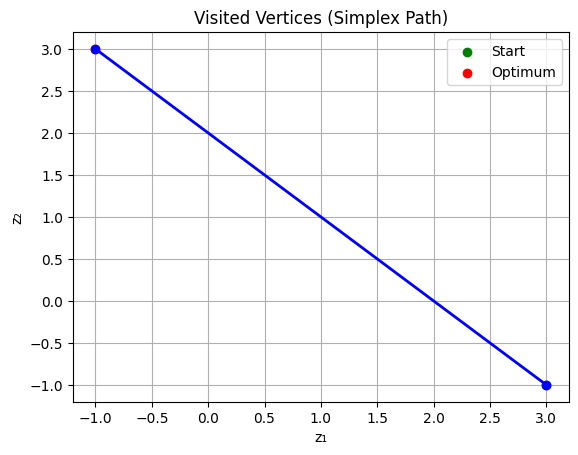

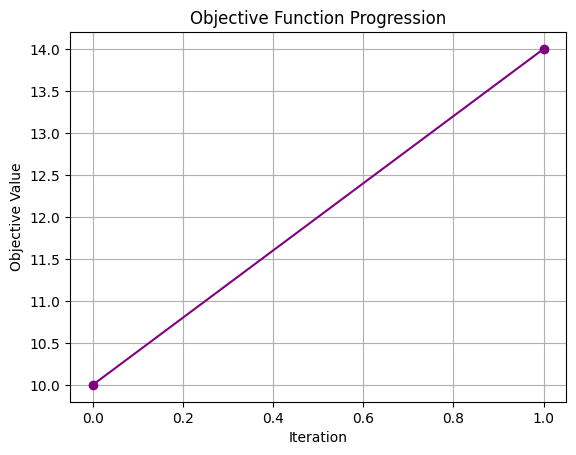

In [53]:
import numpy as np
from sympy import Matrix
import matplotlib.pyplot as plt
import sys

class DegeneratePointError(Exception):
    """Raised when a degenerate vertex is detected."""
    pass

class MyAlgo:
    """
    Custom implementation of the Simplex algorithm for linear programming
    (maximization form), assuming:
        1. Polytope is non-degenerate
        2. Polytope is bounded  (we still detect & report unbounded cleanly)
        3. Rank(A) = number of columns
        4. Initial feasible point is provided
    """

    def __init__(self, filename="Testcase.csv", atol=1e-8):
        data = np.genfromtxt(filename, delimiter=',')
        if data.ndim != 2:
            raise ValueError("CSV must be a 2D array (m+2 rows by n+1 cols).")
        self.z = data[0, :-1]           # initial feasible point,take only 1st row exclude last element
        self.c = data[1, :-1]           # cost vector,take only 2nd row exclude last element
        self.A = data[2:, :-1]          # constraint matrix,from 3rd row to last row but take all column except last column
        self.b = data[2:, -1]           # constraint vector,from 3rd row to last row but take only last column excluding top 2 elements
        self.n = self.A.shape[1]
        self.atol = atol
        self.path = []                 # list of (vertex, value)
        self.unbounded = False         # flag
        np.set_printoptions(precision=4, suppress=True)

        if self.A.shape[0] < self.n:
            raise ValueError("Not enough constraints to define a vertex (need m >= n).")

    # ---------- helpers ----------
    def tight_mask(self):
        return np.isclose(self.A @ self.z, self.b, atol=1e-8)

    def tight_Ab(self):
        mask = self.tight_mask()
        A_t = self.A[mask] if np.any(mask) else np.zeros((0, self.n))
        b_t = self.b[mask] if np.any(mask) else np.zeros((0,))
        return A_t, b_t

    def loose_Ab(self):
        mask = ~self.tight_mask()
        A_l = self.A[mask] if np.any(mask) else np.zeros((0, self.n))
        b_l = self.b[mask] if np.any(mask) else np.zeros((0,))
        return A_l, b_l

    # ---------- degeneracy guard ----------
    def assert_nondegenerate_or_raise(self):
        A_t, _ = self.tight_Ab()
        k = A_t.shape[0]
        if k > self.n:
            raise DegeneratePointError("Degenerate vertex detected — more than n tight constraints.")
        if k >= self.n and np.linalg.matrix_rank(A_t) < self.n:
            raise DegeneratePointError("Degenerate vertex detected — active set is rank-deficient.")

    # ---------- move to boundary (with unbounded detection) ----------
    def move_to_boundary_if_needed(self, max_iter=200):
        """
        From interior to a proper vertex (n tight & full rank).
        If at some step no positive alpha can be found to reach a new boundary,
        declare unbounded and stop cleanly.
        """
        it = 0

        # If no constraints are tight, step to the nearest boundary, then walk edges
        while self.tight_Ab()[0].shape[0] == 0 and it < max_iter:
            slack = self.b - self.A @ self.z
            idx = np.argmin(slack)   # nearest boundary
            a = self.A[idx]
            gap = slack[idx]
            norm_a = np.linalg.norm(a)
            if norm_a < self.atol:
                print(" Numerical issue: near-zero constraint norm.")
                return False
            u = a / norm_a
            # Hit that boundary: a^T(z + αu) = b  ⇒ α = gap / (a^T u) = gap / ||a||
            alpha = gap / norm_a
            if alpha <= self.atol:
                # Already nearly tight or cannot advance — try next step
                break
            self.z = self.z + alpha * u
            it += 1

        # Now walk along edges (nullspace of tight) until we have n independent tights
        while it < max_iter:
            A_t, _ = self.tight_Ab()
            if A_t.shape[0] == self.n and np.linalg.matrix_rank(A_t) == self.n:
                return True  # at a proper vertex

            # edge direction from nullspace
            ns = Matrix(A_t).nullspace() if A_t.size > 0 else [np.eye(self.n)[0]]
            if not ns:
                # cannot move but not a full vertex -> degenerate geometry
                self.assert_nondegenerate_or_raise()  # will raise if degenerate
                print(" Stuck before reaching a vertex (unexpected).")
                return False

            d = np.array(ns[0]).astype(float).flatten()
            d = d / (np.linalg.norm(d) + 1e-16)

            A_l, b_l = self.loose_Ab()
            if A_l.shape[0] == 0:
                # No loose constraints limit movement ⇒ unbounded
                self.unbounded = True
                print(" No solution — the problem is unbounded.")
                return False

            denom = A_l @ d
            # mark truly limiting constraints: those with denom > 0 for z' = z + α d
            pos = denom > self.atol
            if not np.any(pos):
                # No constraint becomes tight in positive direction ⇒ unbounded along d
                self.unbounded = True
                print(" No solution — the problem is unbounded.")
                return False

            alphas = (b_l - A_l @ self.z) / denom
            candidates = alphas[pos]
            candidates = candidates[candidates > self.atol]
            if candidates.size == 0:
                self.unbounded = True
                print(" No solution — the problem is unbounded.")
                return False

            alpha = float(np.min(candidates))
            if not np.isfinite(alpha) or alpha <= self.atol:
                self.unbounded = True
                print(" No solution — the problem is unbounded.")
                return False

            # advance
            self.z = self.z + alpha * d
            it += 1

        print(" Vertex search exceeded iteration limit — possible unbounded problem.")
        self.unbounded = True
        print(" No solution — the problem is unbounded.")
        return False

    # ---------- optimality ----------
    def is_optimal_vertex(self):
        A_t, _ = self.tight_Ab()
        if A_t.shape[0] != self.n or np.linalg.matrix_rank(A_t) != self.n:
            return False
        lambdas = np.linalg.inv(A_t.T) @ self.c
        return np.all(lambdas >= -1e-12)

    # ---------- improving direction ----------
    def improving_direction(self):
        A_t, _ = self.tight_Ab()
        invT = np.linalg.inv(A_t).T
        for row in invT:
            if np.dot(-row, self.c) > 0:
                return row
        return None

    # ---------- max step (with unbounded detection) ----------
    def max_step_to_boundary(self, d):
        """
        For z' = z - α d, find the maximal α ≥ 0 keeping A z' ≤ b.
        If no constraint limits α, return +inf (unbounded).
        """
        A_l, b_l = self.loose_Ab()
        if A_l.shape[0] == 0:
            return np.inf  # nothing limits movement

        denom = A_l @ d
        # constraints that become tight as we move along -d have denom < -tol
        neg = denom < -self.atol
        if not np.any(neg):
            # No constraint will stop us along -d ⇒ unbounded
            return np.inf

        alphas = (A_l @ self.z - b_l) / denom
        candidates = alphas[neg]
        # we need α >= 0
        candidates = candidates[candidates >= -1e-16]
        if candidates.size == 0:
            return np.inf
        return float(np.min(candidates))

    # ---------- main simplex driver ----------
    def solve(self):
        if not np.all(self.A @ self.z <= self.b + 1e-10):
            print("The problem is infeasible due to initial point.")
            return

        # Move to a proper vertex first
        if not self.move_to_boundary_if_needed():
            # Already printed unbounded message if that was the case
            return
        self.assert_nondegenerate_or_raise()

        val = float(self.c @ self.z)
        self.path.append((self.z.copy(), val))
        print(f"sequence of vertices: {self.z} | value of the objective function: {val}")

        # Simplex pivots
        max_iter = 500
        it = 0
        while not self.is_optimal_vertex() and it < max_iter:
            self.assert_nondegenerate_or_raise()
            d = self.improving_direction()
            if d is None:
                break

            alpha = self.max_step_to_boundary(d)
            if not np.isfinite(alpha) or alpha > 1e10:
                self.unbounded = True
                print(" No solution — the problem is unbounded.")
                return

            if alpha <= 1e-16:
                # zero step from vertex -> degeneracy under our assumptions shouldn't happen
                self.assert_nondegenerate_or_raise()
                raise DegeneratePointError("Zero step — degenerate.")

            self.z = self.z - alpha * d
            val = float(self.c @ self.z)
            self.path.append((self.z.copy(), val))
            print(f"sequence of vertices: {self.z} | value of the objective function: {val}")
            it += 1

        if it >= max_iter:
            print(" Iteration cap reached — stopping.")
        # If bounded optimal found, path is printed above.

    # ---------- plotting ----------
    def plot_path(self):
        if self.unbounded:
            print("Unbounded problem — no path plot.")
            return
        if len(self.path) < 2:
            print("Not enough vertices to plot.")
            return
        pts = np.array([p[0] for p in self.path])
        if pts.shape[1] < 2:
            print("Plotting is only supported for 2D.")
            return
        plt.plot(pts[:, 0], pts[:, 1], 'bo-', linewidth=2)
        plt.scatter(pts[0, 0], pts[0, 1], color='green', label='Start')
        plt.scatter(pts[-1, 0], pts[-1, 1], color='red', label='Optimum')
        plt.xlabel('z₁')
        plt.ylabel('z₂')
        plt.title('Visited Vertices (Simplex Path)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_objective(self):
        if self.unbounded or not self.path:
            print("No objective plot (unbounded or empty path).")
            return
        vals = [v for _, v in self.path]
        plt.plot(range(len(vals)), vals, 'o-', color='purple')
        plt.xlabel('Iteration')
        plt.ylabel('Objective Value')
        plt.title('Objective Function Progression')
        plt.grid(True)
        plt.show()


# ------------------- MAIN -------------------
if __name__ == "__main__":
    try:
        solver = MyAlgo("Testcase_2.csv")  # change filename as needed
        solver.solve()
        solver.plot_path()
        solver.plot_objective()
    except DegeneratePointError as e:
        print(str(e))
        sys.exit(0)
    except Exception as e:
        print(f"Error: {e}")
        sys.exit(0)
